In [1]:
import pandas as pd
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import manifold
from typing import Counter
#分群相關套件
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter("ignore")
#視覺化
import matplotlib.pyplot as plt
import seaborn as sns
# 下載相關資料集
nltk.download('vader_lexicon')
nltk.downloader.download('opinion_lexicon')
senti = SentimentIntensityAnalyzer()
PUNCT_TO_REMOVE = string.punctuation+'“”'
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.downloader.download('opinion_lexicon')
nltk.download('wordnet')
nltk.download('twython')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading twython: Package 'twython' not found in
[nltk_data]     index
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

# 匯入資料與文字前處理

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/True.csv')
df['origin_text'] = df['text']

Mounted at /content/drive


In [3]:
#刪除重複資料
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace=True)

In [4]:
#轉小寫
df['text'] = df['text'].apply(lambda x: x.lower())

#去除標點符號
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', PUNCT_TO_REMOVE)))

#去除多餘字
df['text'] = df['text'].apply(lambda x: " ".join([word for word in str(x).split() if word not in STOPWORDS]))

#去除\xa0
df['text'] = df['text'].apply(lambda x: x.replace('\xa0',' '))

# stemming 還原成原形
df['text'] = df['text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

#lemmatization 單複數轉換 
df['text'] = df['text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])) #轉小寫)

In [5]:
#斷詞並去除詞頻少於等於1的詞(只留>1)
word_list = [x.split() for x in df['text']] 
cnt = Counter([word for sent in word_list for word in sent])
FREQTHRES = [x for x in {k: v for k, v in cnt.items() if v > 1}.keys()]
#大概跑個10min
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split(' ') if word in FREQTHRES]))

# 第一題

In [6]:
#使用 nltk 的 SentimentIntensityAnalyzer 計算情感分數
senti = SentimentIntensityAnalyzer()
df['senti_dict'] = df['text'].apply(lambda x : senti.polarity_scores(x))

In [7]:
# 如果pos > neg就將句子視為正面，< 負面, = 中立
def gen_senti_label(_dict):
    if _dict['pos'] > _dict['neg']:
        return 'positive'
    elif _dict['pos'] < _dict['neg']:
        return 'negative'
    else:
        return 'neutral'
df['senti_res'] = df['senti_dict'].apply(lambda x : gen_senti_label(x))

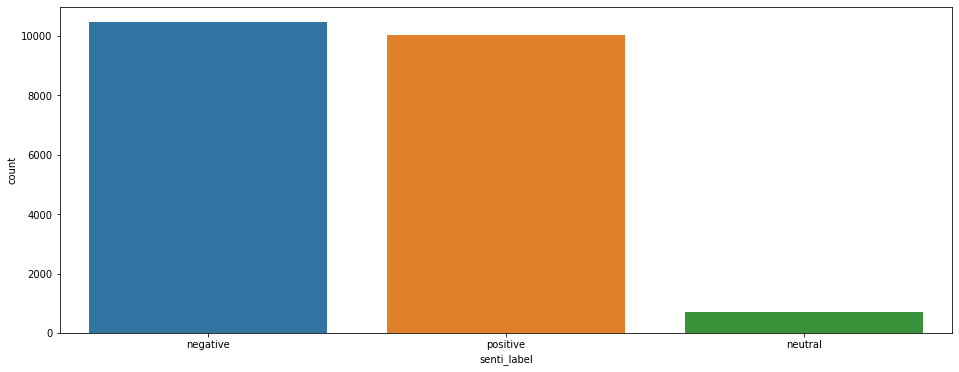

In [12]:
#正負情感標籤結果
senti_df = pd.DataFrame(df['senti_res'].value_counts()).reset_index()
senti_df.columns = ['senti_label','count']
plt.figure(figsize=(16,6))
sns.barplot(x='senti_label',y='count',data = senti_df)

# 第二題

In [16]:
#轉換成tf_idf矩陣
tf_vectorizer = CountVectorizer()
tf_vectorizer.fit(df['text']) #得到欄位名稱
tf_X = tf_vectorizer.transform(df['text']).toarray() 

In [34]:
tf_df = pd.DataFrame(tf_X)
tf_df.columns = tf_vectorizer.get_feature_names_out()
tf_df.loc[:,tf_df.columns[5000]:]

,authorit,authoritarian,authorities,authority,autism,autist,auto,autobiographi,autocraci,autocrat,autograph,autoimmun,autoinject,autoinjector,autolit,autom,automak,automaker,automakers,automat,automobil,automot,autonom,autonomi,autonomist,autonomyseek,autopart,autopilot,autopsi,autorel,autorickshaw,autozon,autumn,auvil,auviq,auxiliari,avaaz,avail,avakov,avalanch,...,zoo,zoom,zoomph,zor,zoran,zou,zschaep,zubaidi,zubair,zubik,zucker,zuckerberg,zuckerman,zuffa,zuhri,zukin,zulia,zulkarnain,zulkifli,zulu,zuma,zumba,zummar,zuniga,zuo,zuoan,zuocheng,zuoxiao,zurich,zuwara,zuweid,zuzhou,zvizdic,zwak,zweiman,zweli,zwolinski,zynga,zypri,zyuganov
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# 使用t-SNE降成2維，利於視覺化，大概跑15min
tsne_res = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(tf_X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 21211 samples in 0.731s...
[t-SNE] Computed neighbors for 21211 samples in 602.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21211
[t-SNE] Computed conditional probabilities for sample 2000 / 21211
[t-SNE] Computed conditional probabilities for sample 3000 / 21211
[t-SNE] Computed conditional probabilities for sample 4000 / 21211
[t-SNE] Computed conditional probabilities for sample 5000 / 21211
[t-SNE] Computed conditional probabilities for sample 6000 / 21211
[t-SNE] Computed conditional probabilities for sample 7000 / 21211
[t-SNE] Computed conditional probabilities for sample 8000 / 21211
[t-SNE] Computed conditional probabilities for sample 9000 / 21211
[t-SNE] Computed conditional probabilities for sample 10000 / 21211
[t-SNE] Computed conditional probabilities for sample 11000 / 21211
[t-SNE] Computed conditional probabilities for sample 12000 / 21211
[t-SNE] Computed conditional probabilities for s

In [20]:
#t-SNE 結果
tsne_df = pd.DataFrame(tsne_res)
tsne_df

,0,1
0,-53.784622,23.091883
1,-7.563096,24.868452
2,-37.804489,-32.172546
3,-36.723690,-32.125786
4,-29.592033,-8.233652
...,...,...
21206,1.542265,19.560032
21207,9.875473,43.903984
21208,12.878684,18.930723
21209,8.880972,-22.562115


In [21]:
df['tsne_0'] = tsne_df[0]
df['tsne_1'] = tsne_df[1]
tsne_df = df[['tsne_0','tsne_1']]

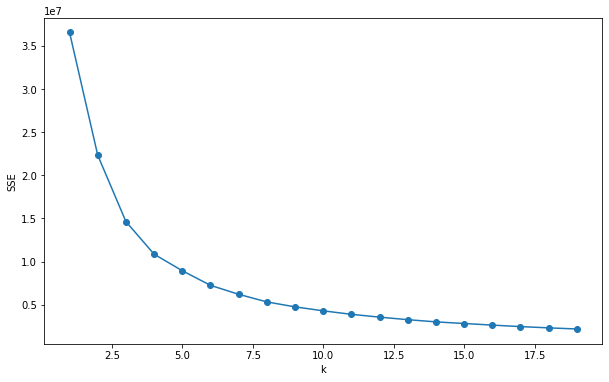

In [23]:
# 手肘法決定適合分群數，但不理想(找不太到手肘感覺是3)
SSE = []
for i in range(1,20):
    estimator = KMeans(n_clusters=i)  
    estimator.fit(tsne_df.values)
    SSE.append(estimator.inertia_)
plt.figure(figsize=(10, 6))
x = range(1,20)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(x,SSE,'o-')

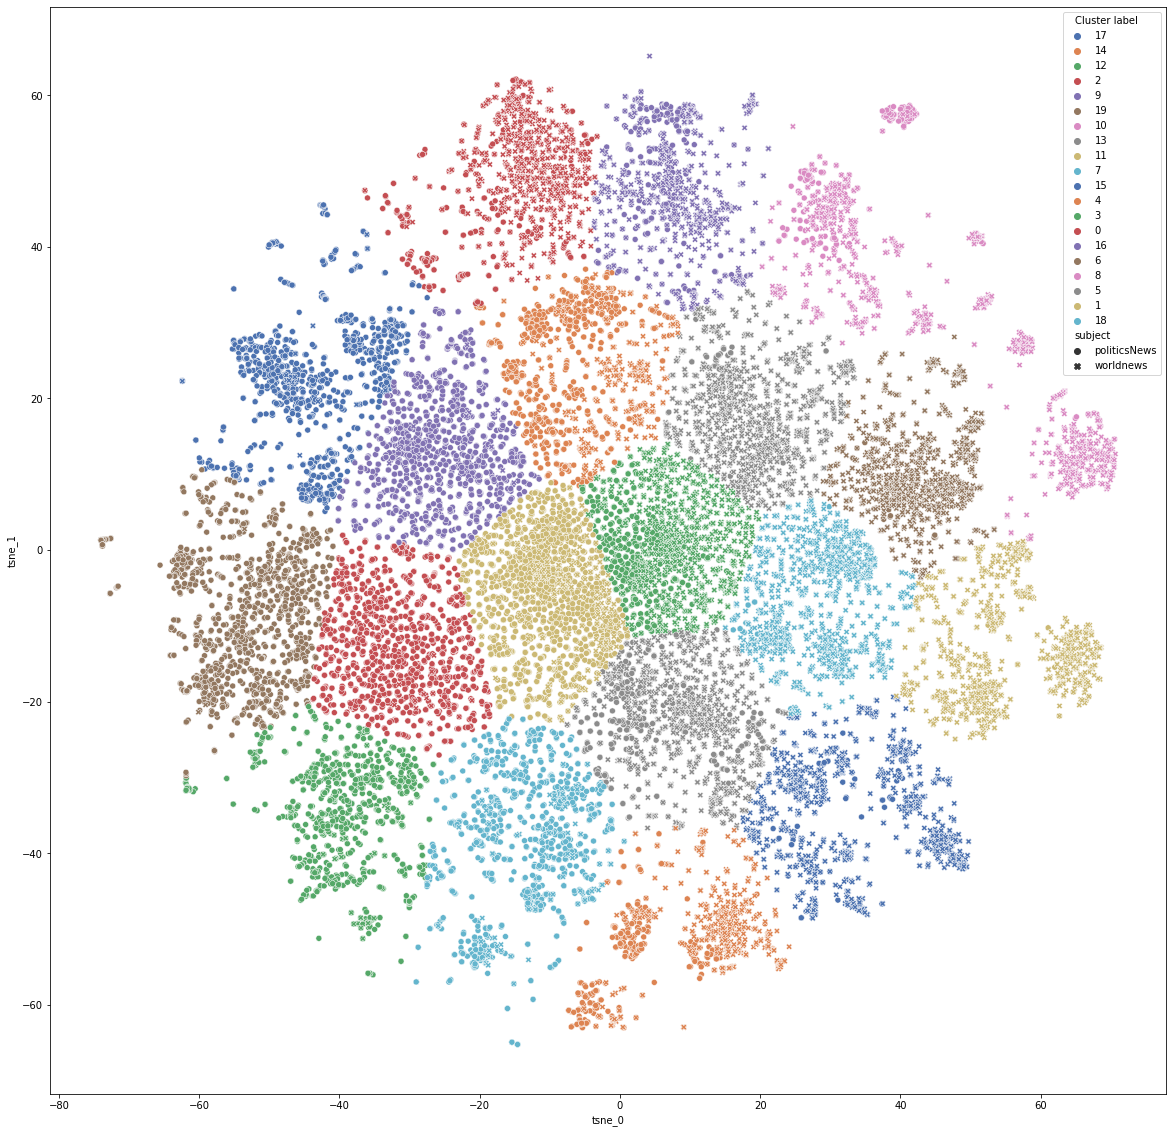

In [24]:
#k-means(暫時)分20群，效果不太佳(有明顯的分界線)
kmeans = KMeans(n_clusters=20)
kmeans.fit(tsne_df[['tsne_0','tsne_1']])
labels = [str(x) for x in kmeans.predict(tsne_df[['tsne_0','tsne_1']])]
tsne_df['Cluster label'] = labels
df['Cluster label'] = labels
plt.figure(figsize=(20, 20))
sns.scatterplot(data=tsne_df, x='tsne_0', y='tsne_1', hue=df['Cluster label'], palette="deep", style = df["subject"])

In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

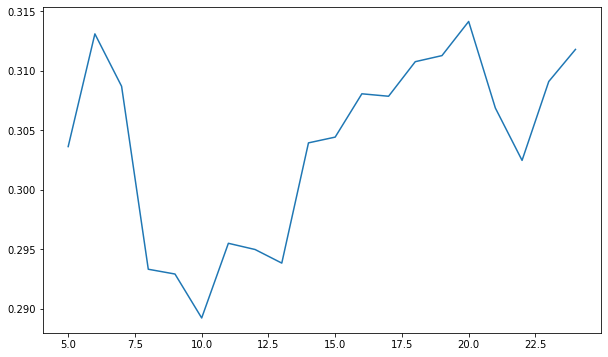

In [31]:
# 這裡改用輪廓分析法找階層式分群的最佳分群數=20(找高)
silhouette_avg = []
for i in range(5,25):
    ml = AgglomerativeClustering(n_clusters=i,affinity='euclidean',linkage='ward')
    labels = ml.fit_predict(tsne_df[['tsne_0','tsne_1']])
    silhouette_avg.append(silhouette_score(tsne_df[['tsne_0','tsne_1']], labels))
plt.figure(figsize=(10, 6))
plt.plot(range(5,25), silhouette_avg)

In [32]:
ml = AgglomerativeClustering(n_clusters=20,affinity='euclidean',linkage='ward')
df['Cluster label2'] = ml.fit_predict(tsne_df[['tsne_0','tsne_1']])

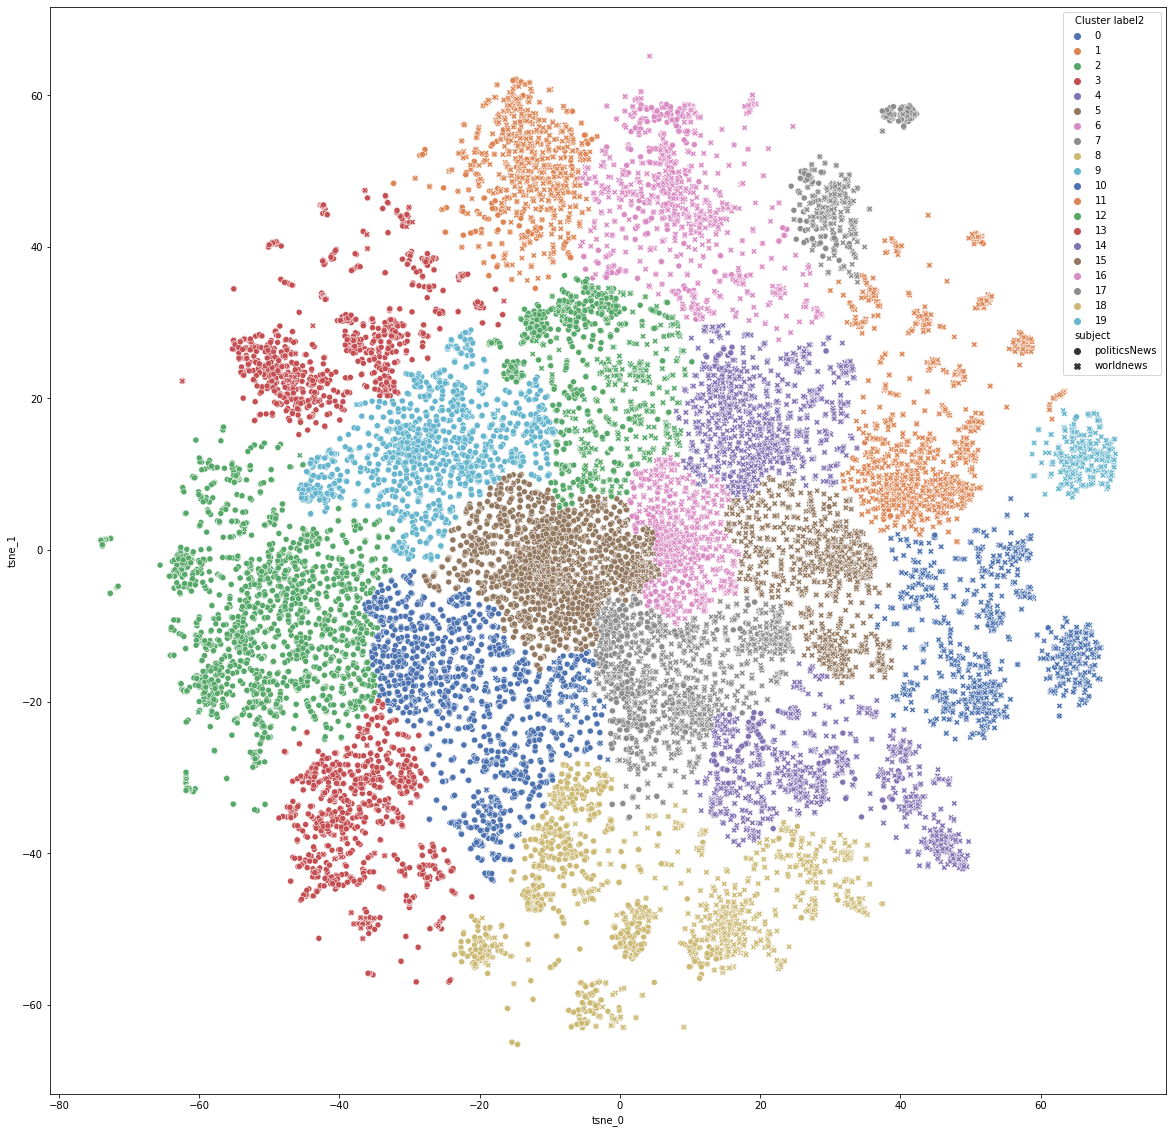

In [33]:
plt.figure(figsize=(20, 20))
sns.scatterplot(data=tsne_df, x='tsne_0', y='tsne_1', hue=df['Cluster label2'], palette="deep", style = df["subject"])

# 第三題

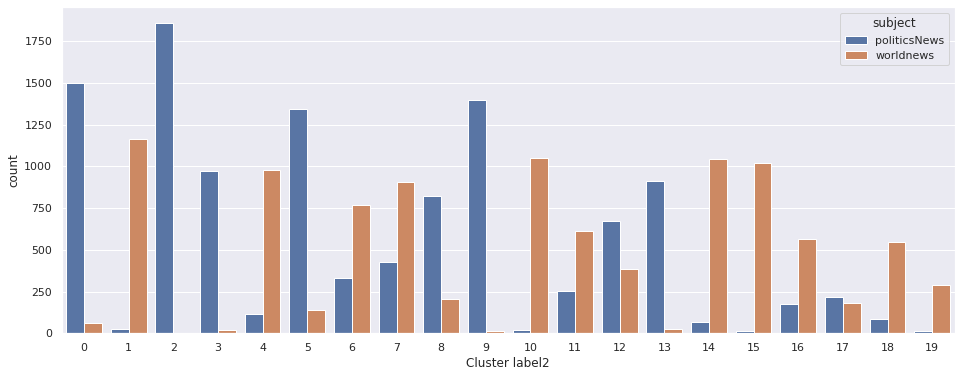

In [ ]:
#找出每一群分布懸殊的新聞視為bias(表示這個新聞的內容可能比較像另一個subject)
sns.set(font_scale=1)
plt.figure(figsize=(16, 6))
sns.countplot(x="Cluster label2",hue='subject', data=df)

In [35]:
#由上圖制定bias新聞的規則
def bias_news_rule(sub,labels):
    if (sub != 'politicsNews'):
        if labels in [0,3,9,13]:
            return 1
        else:
            return 0
    else:
        if labels in [1,10,15,19]:
            return 1  
        else:
            return 0

In [36]:
df['is_bias'] = df.apply(lambda x : bias_news_rule(x['subject'] ,x['Cluster label2']), axis =1)

In [37]:
df[df.is_bias == 1] #結果大概有190篇

,title,text,subject,date,origin_text,senti_dict,senti_res,tsne_0,tsne_1,Cluster label,Cluster label2,is_bias
548,U.S. calls Myanmar moves against Rohingya 'eth...,washington reuter unit state wednesday call my...,politicsNews,"November 22, 2017",WASHINGTON (Reuters) - The United States on We...,"{'neg': 0.104, 'neu': 0.81, 'pos': 0.086, 'com...",negative,68.541901,16.337570,8,19,1
571,U.S. Congress members decry 'ethnic cleansing'...,yangonnaypyitaw reuter member u congress said ...,politicsNews,"November 21, 2017",YANGON/NAYPYITAW (Reuters) - Members of the U....,"{'neg': 0.119, 'neu': 0.78, 'pos': 0.101, 'com...",negative,70.535866,14.615525,8,19,1
574,Myanmar operation against Rohingya has 'hallma...,yangon reuter member u congress said tuesday d...,politicsNews,"November 21, 2017",YANGON (Reuters) - Members of U.S. Congress sa...,"{'neg': 0.21, 'neu': 0.761, 'pos': 0.029, 'com...",negative,65.282471,12.176594,8,19,1
764,White House condemns missile attacks on Saudi ...,beij reuter white hous wednesday condemn missi...,politicsNews,"November 8, 2017",BEIJING (Reuters) - The White House on Wednesd...,"{'neg': 0.245, 'neu': 0.746, 'pos': 0.009, 'co...",negative,34.827362,36.048805,10,1,1
803,India orders investigation after Paradise Pape...,new delhi reuter india monday form panel gover...,politicsNews,"November 6, 2017",NEW DELHI (Reuters) - India on Monday formed a...,"{'neg': 0.066, 'neu': 0.904, 'pos': 0.03, 'com...",negative,16.944109,2.165535,3,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20711,FBI says witnesses in U.S. probe into Malaysia...,kuala lumpur reuter potenti wit multibillion d...,worldnews,"September 6, 2017",KUALA LUMPUR (Reuters) - Potential witnesses t...,"{'neg': 0.115, 'neu': 0.82, 'pos': 0.065, 'com...",negative,-7.527738,-23.033066,13,0,1
20712,"Mexico, El Salvador, Guatemala urge protection...",mexico citi reuter mexico central american cou...,worldnews,"September 5, 2017",MEXICO CITY (Reuters) - Mexico and Central Ame...,"{'neg': 0.068, 'neu': 0.848, 'pos': 0.084, 'co...",positive,-18.983067,-31.685749,7,0,1
20713,Mexican families of 'Dreamers' tell them to ke...,mexico citi reuter varona encourag child thous...,worldnews,"September 6, 2017",MEXICO CITY (Reuters) - Yolanda Varona is enco...,"{'neg': 0.122, 'neu': 0.766, 'pos': 0.113, 'co...",negative,-19.019697,-31.637629,7,0,1
20876,Mother's fight to discover fate of dead baby's...,edinburgh reuter mother fight four decad find ...,worldnews,"September 4, 2017",EDINBURGH (Reuters) - A mother who has been fi...,"{'neg': 0.164, 'neu': 0.755, 'pos': 0.081, 'co...",negative,-1.710206,-27.666098,13,0,1


In [38]:
df[df.is_bias == 1].iloc[0]['origin_text']

'WASHINGTON (Reuters) - The United States on Wednesday called the Myanmar military operation against the Rohingya population “ethnic cleansing” and  threatened targeted sanctions against those responsible for what it called “horrendous atrocities.” “The situation in northern Rakhine state constitutes ethnic cleansing against the Rohingya,” U.S. Secretary of State Rex Tillerson said in a statement, using a term he avoided when visiting Myanmar, also known as Burma, last week. “The United States will also pursue accountability through U.S. law, including possible targeted sanctions” against those responsible for the alleged abuses, which have driven hundreds of thousands of Rohingya into neighboring Bangladesh, he said. The United States shifted its stance in part to raise pressure on Myanmar’s military and civilian leaders, who have shared power for the past two years under an uneasy arrangement after decades of military rule, to address the crisis. Rights monitors accused Myanmar’s mil

# END